In [2]:
import numpy as np
import pandas as pd

class LungCancerProgressionGenerator:
    def __init__(self, num_patients, years=15):
        self.num_patients = num_patients
        self.months = years * 12
        self.states = ['Healthy', 'Stage I', 'Stage II', 'Stage III', 'Stage IV', 'Death']
        self.doubling_time = 134 / 30  # Convert 134 days to months
        
        # Age-specific cancer occurrence rates (annual per 100,000) for ages 50-70
        self.cancer_rates = {
            (50, 54): 33.2, (55, 59): 79.9, (60, 64): 140.5,
            (65, 69): 198.4, (70, 74): 262.8
        }
        
        # Survival rates by stage
        self.survival_rates = {
            1: {'1year': 0.7112, '5year': 0.3533},
            2: {'1year': 0.4815, '5year': 0.2089},
            3: {'1year': 0.3495, '5year': 0.0632},
            4: {'1year': 0.1436, '5year': 0.0}
        }

    def get_cancer_rate(self, age):
        for (lower, upper), rate in self.cancer_rates.items():
            if lower <= age <= upper:
                return rate / 100000 / 12  # Convert to monthly rate
        return self.cancer_rates[(65, 69)] / 100000 / 12  # Default to 85+ rate

    def get_monthly_death_probability(self, stage, months_since_diagnosis):
        if stage == 0:  # Healthy
            return 0.0
        
        # if months_since_diagnosis <= 12:
        yearly_survival = self.survival_rates[stage]['1year']
        # else:
        #     yearly_survival = self.survival_rates[stage]['5year']
        
        monthly_survival = yearly_survival ** (1/12)
        return 1 - monthly_survival

    def diagnose_cancer(self, current_state, use_blood_test = False):
        if use_blood_test:
            return current_state  # Perfect detection with blood test
        else:
            # 70% chance to diagnose late stages if no blood test and 30% chance for early stages
            if current_state == 1 or current_state == 2:
                rand = np.random.random()
                if rand < 0.3:
                    return current_state
            elif current_state == 3 or current_state == 4:
                rand = np.random.random()
                if rand < 0.7:
                    return current_state
            return 0  # Cancer not detected

    def generate_patient_trajectory(self, patient_id, use_blood_test=False):
        trajectory = []
        current_state = 0  # Start in Healthy state
        age = 50 # Random starting age between 50 and 70
        cancer_time = 0  # Time since cancer onset
        months_since_diagnosis = -1  # -1 indicates cancer has not been diagnosed
        months_since_last_test = 0
        diagnosis_month = None
        doublings = 0  # Number of doublings needed for next stage
        
        for month in range(self.months):
            origin_state = current_state
            target_state = current_state  # Initialize target_state to current_state
            
            if current_state == 0:  # Healthy state
                
                cancer_prob = self.get_cancer_rate(age)
                
                if np.random.random() < cancer_prob:
                    target_state = 1  # Cancer starts at Stage I
                    cancer_time = 0
                    doublings = 0

                    diagnosed_state = self.diagnose_cancer(target_state)
                    if diagnosed_state > 0:
                        target_state = diagnosed_state
                        months_since_diagnosis = 0
                        diagnosis_month = month
            
            elif 1 <= current_state <= 4:  # Cancer stages I-IV
                if months_since_diagnosis >= 0:  # Only increment if cancer has been diagnosed
                    months_since_diagnosis += 1
                cancer_time += 1
                
                # Check for death
                death_prob = self.get_monthly_death_probability(current_state, months_since_diagnosis)
                if np.random.random() < death_prob:
                    target_state = 5  # Death state
                elif cancer_time >= self.doubling_time * (doublings + 1) and current_state < 4:
                    target_state = current_state + 1
                    cancer_time = 0  # Reset cancer time for the new stage
                    doublings = 0  # Reset doublings for the new stage
                    if months_since_diagnosis == -1:  # Only check for diagnosis if not yet diagnosed
                        diagnosed_state = self.diagnose_cancer(target_state, use_blood_test)
                        if diagnosed_state > 0:
                            # target_state = diagnosed_state
                            months_since_diagnosis = 0
                            diagnosis_month = month
                else:
                    doublings = int(cancer_time / self.doubling_time)  # Update doublings count
    
            # Blood test every 2 years (24 months)
            if use_blood_test and months_since_last_test >= 24 and months_since_diagnosis == -1:
                months_since_last_test = 0
                if target_state > 0:  # If cancer is present
                    months_since_diagnosis = 0
                    diagnosis_month = month
    
            if target_state != 0 or current_state != 0:  # Only record non-Healthy states
                trajectory.append({
                    'sample_id': patient_id,
                    'origin_state': origin_state,
                    'target_state': target_state,
                    'months_since_diagnosis': months_since_diagnosis,
                    'age_at_diagnosis': age - (month - diagnosis_month) / 12 if months_since_diagnosis >= 0 else None,
                    'time_entry_to_origin': month,
                    'time_transition_to_target': month + 1
                })
            
            if target_state == 5:  # If patient has died, stop tracking
                break
            
            current_state = target_state  # Update current_state for the next iteration
            age += 1/12  # Increase age by 1 month
            months_since_last_test += 1
    
        return trajectory

    def generate_dataset(self, use_blood_test=False):
        all_trajectories = []
        for i in range(self.num_patients):
            all_trajectories.extend(self.generate_patient_trajectory(i, use_blood_test))
        
        return pd.DataFrame(all_trajectories)

# Generate datasets for both scenarios
generator = LungCancerProgressionGenerator(num_patients=10000)
df_without_test = generator.generate_dataset(use_blood_test=False)
df_with_test = generator.generate_dataset(use_blood_test=True)

# Function to calculate and print statistics
def print_statistics(df, scenario):
    print(f"\nStatistics for {scenario}:")
    print(f"Total number of diagnosed patients: {df['sample_id'].nunique()}")
    
    # Distribution of cancer stages at diagnosis
    stage_at_diagnosis = df[df['months_since_diagnosis'] == 0]['target_state'].value_counts(normalize=True).to_dict()
    print("\nDistribution of cancer stages at diagnosis:")
    for stage, count in stage_at_diagnosis.items():
        print(f"Stage {stage}: {count * 100:.2f}%")
    
    # Percentage of late-stage diagnoses (Stage III and IV)
    late_stage = (stage_at_diagnosis.get(3, 0) + stage_at_diagnosis.get(4, 0))
    print(f"\nPercentage of late-stage diagnoses (Stage III and IV): {late_stage * 100:.2f}%")
    
    # 1-year survival rate
    total_patients = df['sample_id'].nunique()
    patients_1year = df.groupby('sample_id').filter(lambda x: x['months_since_diagnosis'].max() > 12)
    survival_rate_1year = patients_1year['sample_id'].count() / total_patients
    # print(survival_rate_1year)
    print(f"\n1-year survival rate: {survival_rate_1year:.2f}")
    
    # Average age at diagnosis
    avg_age_at_diagnosis = df.groupby('sample_id')['age_at_diagnosis'].first().mean()
    print(f"\nAverage age at diagnosis: {avg_age_at_diagnosis:.2f} years")

    # # Average time spent in each state
    # state_durations = df.groupby('sample_id').apply(lambda x: x.groupby('origin_state')['time_transition_to_target'].diff().mean())
    # print("\nAverage time spent in each state (months):")
    # for state, duration in state_durations.mean().items():
    #     if state != 0 and not np.isnan(duration):  # Exclude Healthy state and NaN values
    #         print(f"State {state}: {duration:.2f}")

# Print statistics for both scenarios
print_statistics(df_without_test, "Without Blood Test")
print_statistics(df_with_test, "With Perfect Biennial Blood Test")

# Save the datasets to CSV files
df_without_test.to_csv('lung_cancer_data_15years_without_blood_test_accurate.csv', index=False)
df_with_test.to_csv('lung_cancer_data_15years_with_perfect_biennial_blood_test.csv', index=False)
print("\nData saved to 'lung_cancer_data_15years_without_blood_test_accurate.csv' and 'lung_cancer_data_15years_with_perfect_biennial_blood_test.csv'")


Statistics for Without Blood Test:
Total number of diagnosed patients: 169

Distribution of cancer stages at diagnosis:
Stage 1: 34.75%
Stage 2: 33.05%
Stage 3: 26.27%
Stage 4: 5.93%

Percentage of late-stage diagnoses (Stage III and IV): 32.20%

1-year survival rate: 5.67

Average age at diagnosis: 58.99 years

Statistics for With Perfect Biennial Blood Test:
Total number of diagnosed patients: 152

Distribution of cancer stages at diagnosis:
Stage 1: 51.09%
Stage 2: 48.91%

Percentage of late-stage diagnoses (Stage III and IV): 0.00%

1-year survival rate: 7.95

Average age at diagnosis: 59.61 years

Data saved to 'lung_cancer_data_15years_without_blood_test_accurate.csv' and 'lung_cancer_data_15years_with_perfect_biennial_blood_test.csv'


In [3]:
df_without_test

,sample_id,origin_state,target_state,months_since_diagnosis,age_at_diagnosis,time_entry_to_origin,time_transition_to_target
0,68,0,1,-1,NaN,116,117
1,68,1,1,-1,NaN,117,118
2,68,1,1,-1,NaN,118,119
3,68,1,1,-1,NaN,119,120
4,68,1,1,-1,NaN,120,121
...,...,...,...,...,...,...,...
2394,9991,2,2,-1,NaN,156,157
2395,9991,2,2,-1,NaN,157,158
2396,9991,2,2,-1,NaN,158,159
2397,9991,2,2,-1,NaN,159,160


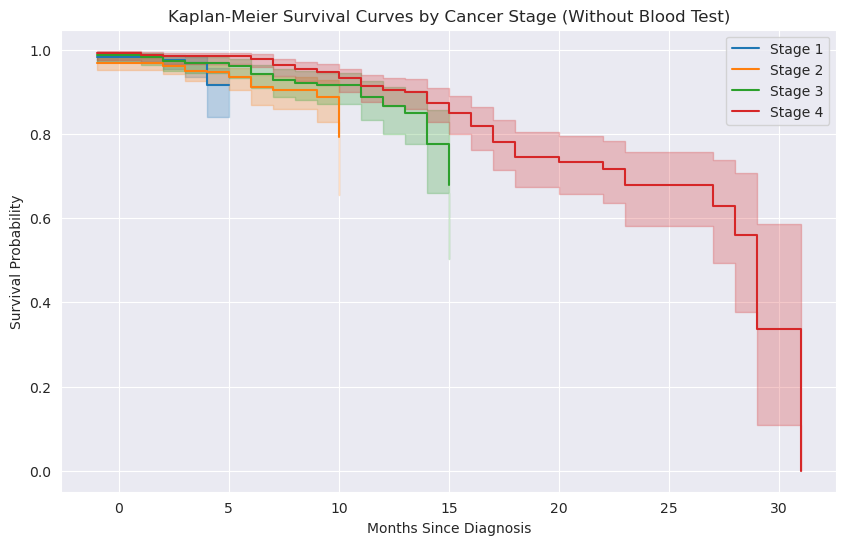

In [4]:
# plot competing risks for each stage
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test

# Create a Kaplan-Meier plot for each stage
fig, ax = plt.subplots(figsize=(10, 6))
kmf = KaplanMeierFitter()

for stage in range(1, 5):
    data = df_without_test[df_without_test['origin_state'] == stage]
    kmf.fit(data['months_since_diagnosis'], event_observed=data['target_state'] == 5, label=f'Stage {stage}')
    kmf.plot(ax=ax)
    
plt.title('Kaplan-Meier Survival Curves by Cancer Stage (Without Blood Test)')
plt.xlabel('Months Since Diagnosis')
plt.ylabel('Survival Probability')
plt.show()

In [6]:
proportions

NameError: name 'proportions' is not defined

/tmp/ipykernel_532014/1802046487.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aligned_df = df.groupby('sample_id').apply(adjust_time).reset_index(drop=True)
/tmp/ipykernel_532014/1802046487.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('RdYlBu')(np.linspace(0.1, 0.9, len(states)))


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

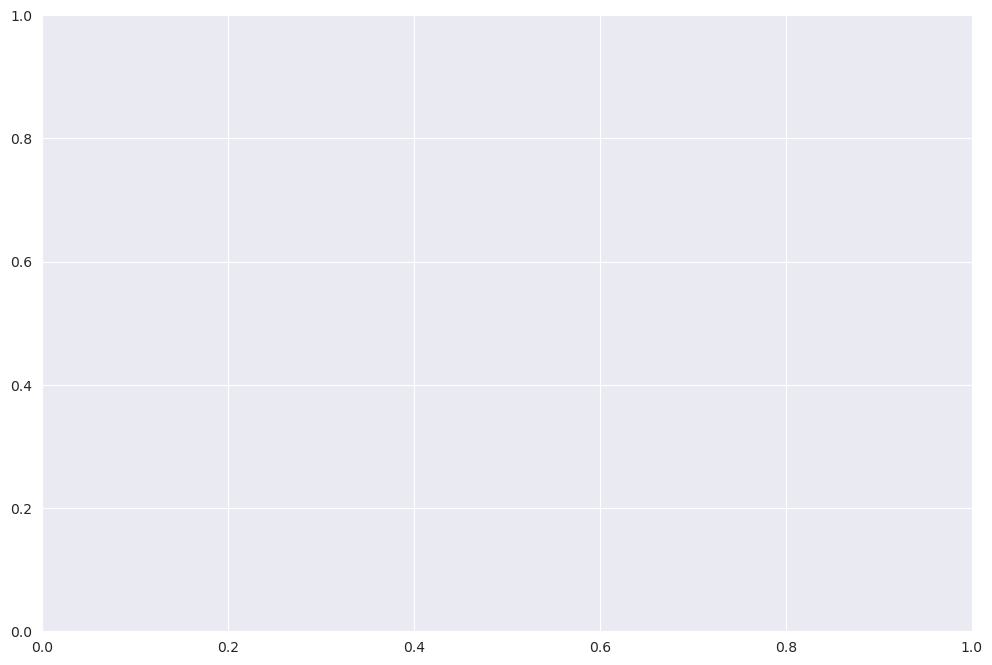

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def align_to_diagnosis(df):
    # Group by patient and find the diagnosis point
    diagnosis_points = df[df['months_since_diagnosis'] == 0].groupby('sample_id')['time_entry_to_origin'].first()
    
    # Function to adjust time for each patient
    def adjust_time(group):
        patient_id = group['sample_id'].iloc[0]
        diagnosis_time = diagnosis_points.get(patient_id, np.inf)
        group['adjusted_time'] = group['time_entry_to_origin'] - diagnosis_time
        return group

    # Apply the adjustment to each patient's trajectory
    aligned_df = df.groupby('sample_id').apply(adjust_time).reset_index(drop=True)
    
    # Filter out pre-diagnosis data points and any rows with inf values
    aligned_df = aligned_df[(aligned_df['adjusted_time'] >= 0) & (aligned_df['adjusted_time'] != np.inf)]
    
    # Check that patient was diagnosed
    diagnosed_patients = aligned_df[aligned_df['months_since_diagnosis'] == 0]['sample_id'].unique()
    aligned_df = aligned_df[aligned_df['sample_id'].isin(diagnosed_patients)]
    
    return aligned_df

def create_stacked_area_chart(df, title):
    # Align data to diagnosis point
    aligned_df = align_to_diagnosis(df)
    
    # Ensure all columns are numeric
    for col in aligned_df.columns:
        if aligned_df[col].dtype == 'object':
            aligned_df[col] = pd.to_numeric(aligned_df[col], errors='coerce')
    
    # Remove any rows with NaN values
    aligned_df = aligned_df.dropna()
    
    # Process the aligned data
    time_points = sorted(aligned_df['adjusted_time'].unique())
    states = sorted(aligned_df['target_state'].unique())
    
    # Create a DataFrame to hold the proportions
    proportions = pd.DataFrame(index=time_points, columns=states)
    
    
    
    # Calculate proportions for each state at each time point
    for time in time_points:
        time_slice = aligned_df[aligned_df['adjusted_time'] == time]
        state_counts = time_slice['target_state'].value_counts()
        total = len(time_slice['sample_id'].unique())
        for state in states:
            proportions.loc[time, state] = state_counts.get(state, 0) / total if total > 0 else 0
            

    # Create the stacked area plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Custom color palette
    colors = plt.cm.get_cmap('RdYlBu')(np.linspace(0.1, 0.9, len(states)))
    
    ax.stackplot(proportions.index, proportions.T, labels=states, colors=colors)
    
    # Customize the plot
    ax.set_xlabel('Time since diagnosis (months)')
    ax.set_ylabel('Proportion')
    ax.set_title(title)
    ax.legend(title='States', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlim(0, max(time_points))
    ax.set_ylim(0, 1)
    
    # Add gridlines
    ax.grid(True, alpha=0.3)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Assuming df_without_test and df_with_test are your DataFrames
create_stacked_area_chart(df_without_test, "Cancer Progression Without Blood Test")
create_stacked_area_chart(df_with_test, "Cancer Progression With Blood Test")

In [52]:
df = df_without_test

aligned_df = align_to_diagnosis(df)
    
# Ensure all columns are numeric
for col in aligned_df.columns:
    if aligned_df[col].dtype == 'object':
        aligned_df[col] = pd.to_numeric(aligned_df[col], errors='coerce')

# Remove any rows with NaN values
aligned_df = aligned_df.dropna()

# Process the aligned data
time_points = sorted(aligned_df['adjusted_time'].unique())
states = sorted(aligned_df['target_state'].unique())

# Create a DataFrame to hold the proportions
proportions = pd.DataFrame(index=time_points, columns=states)

# Calculate proportions for each state at each time point
for time in time_points:
    time_slice = aligned_df[aligned_df['adjusted_time'] == time]
    state_counts = time_slice['target_state'].value_counts()
    total = len(time_slice['sample_id'].unique())
    for state in states:
        proportions.loc[time, state] = state_counts.get(state, 0) / total if total > 0 else 0

/tmp/ipykernel_532014/1802046487.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aligned_df = df.groupby('sample_id').apply(adjust_time).reset_index(drop=True)


In [76]:
# If a person died before 32 months, fill the missing time points with the last known state
max_time = max(aligned_df['adjusted_time'])
ids = aligned_df['sample_id'].unique()

for patient_id in ids:
    patient_data = aligned_df[aligned_df['sample_id'] == patient_id]
    if patient_data['target_state'].iloc[-1] == 5:
        last_state = patient_data['target_state'].iloc[-1]
        for time in range(int(max_time)):
            if time not in patient_data['adjusted_time'].values:
                to_concat = patient_data.iloc[-1].copy()
                to_concat['adjusted_time'] = time
                to_concat['time_entry_to_origin'] = time
                to_concat['time_transition_to_target'] = time
                
                aligned_df = pd.concat([aligned_df, to_concat], ignore_index=True)

IndexError: single positional indexer is out-of-bounds

In [75]:
aligned_df[aligned_df['sample_id'] == 68.0]

,sample_id,origin_state,target_state,months_since_diagnosis,age_at_diagnosis,time_entry_to_origin,time_transition_to_target,adjusted_time,0
0,68.0,1.0,2.0,0.0,60.083333,121.0,122.0,0.0,NaN
1,68.0,2.0,2.0,1.0,60.083333,122.0,123.0,1.0,NaN
2,68.0,2.0,2.0,2.0,60.083333,123.0,124.0,2.0,NaN
3,68.0,2.0,5.0,3.0,60.083333,124.0,125.0,3.0,NaN


In [74]:
# sort by sample_id and adjusted_time
aligned_df = aligned_df.sort_values(by=['sample_id', 'adjusted_time'])
aligned_df

,sample_id,origin_state,target_state,months_since_diagnosis,age_at_diagnosis,time_entry_to_origin,time_transition_to_target,adjusted_time,0
0,68.0,1.0,2.0,0.0,60.083333,121.0,122.0,0.0,NaN
1,68.0,2.0,2.0,1.0,60.083333,122.0,123.0,1.0,NaN
2,68.0,2.0,2.0,2.0,60.083333,123.0,124.0,2.0,NaN
3,68.0,2.0,5.0,3.0,60.083333,124.0,125.0,3.0,NaN
4,211.0,1.0,2.0,0.0,55.583333,67.0,68.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...
20540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.416667
20541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.000000
20542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.000000
20543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.000000


In [65]:
aligned_df

,sample_id,origin_state,target_state,months_since_diagnosis,age_at_diagnosis,time_entry_to_origin,time_transition_to_target,adjusted_time
5,68,1,2,0,60.083333,121,122,0.0
6,68,2,2,1,60.083333,122,123,1.0
7,68,2,2,2,60.083333,123,124,2.0
8,68,2,5,3,60.083333,124,125,3.0
14,211,1,2,0,55.583333,67,68,0.0
...,...,...,...,...,...,...,...,...
2380,9982,2,2,2,56.416667,79,80,2.0
2381,9982,2,2,3,56.416667,80,81,3.0
2382,9982,2,2,4,56.416667,81,82,4.0
2383,9982,2,3,5,56.416667,82,83,5.0


In [62]:
#save proportions to csv
proportions.to_csv('proportions.csv')

In [55]:
pd.to_numeric(proportions[''])

TypeError: arg must be a list, tuple, 1-d array, or Series

In [58]:
x=range(1,6)
y=[ [1,4,6,8,9], [2,2,7,10,12], [2,8,5,10,6] ]

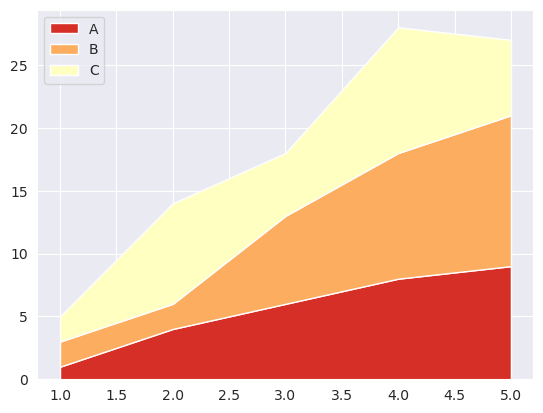

In [61]:
plt.stackplot(x,y, labels=['A','B','C'])
plt.legend(loc='upper left')
plt.show()

/tmp/ipykernel_532014/1687311063.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('RdYlBu')(np.linspace(0.1, 0.9, len(df.columns)))


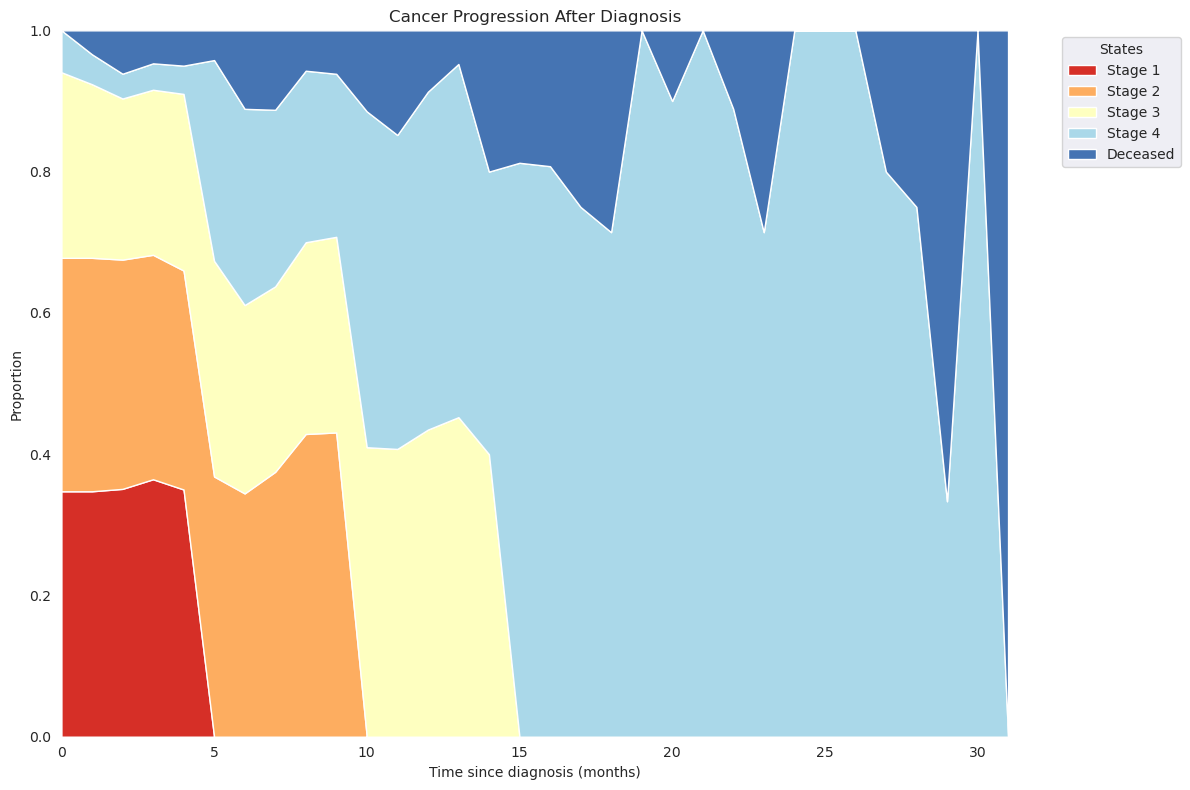

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import io

# Load the data
data = """
0.0,0.3474576271186441,0.3305084745762712,0.2627118644067797,0.059322033898305086,0.0
1.0,0.3474576271186441,0.3305084745762712,0.2457627118644068,0.0423728813559322,0.03389830508474576
2.0,0.3508771929824561,0.32456140350877194,0.22807017543859648,0.03508771929824561,0.06140350877192982
3.0,0.3644859813084112,0.3177570093457944,0.2336448598130841,0.037383177570093455,0.04672897196261682
4.0,0.35,0.31,0.25,0.04,0.05
5.0,0.0,0.3684210526315789,0.30526315789473685,0.28421052631578947,0.042105263157894736
6.0,0.0,0.34444444444444444,0.26666666666666666,0.2777777777777778,0.1111111111111111
7.0,0.0,0.375,0.2625,0.25,0.1125
8.0,0.0,0.42857142857142855,0.2714285714285714,0.24285714285714285,0.05714285714285714
9.0,0.0,0.4307692307692308,0.27692307692307694,0.23076923076923078,0.06153846153846154
10.0,0.0,0.0,0.4098360655737705,0.47540983606557374,0.11475409836065574
11.0,0.0,0.0,0.4074074074074074,0.4444444444444444,0.14814814814814814
12.0,0.0,0.0,0.43478260869565216,0.4782608695652174,0.08695652173913043
13.0,0.0,0.0,0.4523809523809524,0.5,0.047619047619047616
14.0,0.0,0.0,0.4,0.4,0.2
15.0,0.0,0.0,0.0,0.8125,0.1875
16.0,0.0,0.0,0.0,0.8076923076923077,0.19230769230769232
17.0,0.0,0.0,0.0,0.75,0.25
18.0,0.0,0.0,0.0,0.7142857142857143,0.2857142857142857
19.0,0.0,0.0,0.0,1.0,0.0
20.0,0.0,0.0,0.0,0.9,0.1
21.0,0.0,0.0,0.0,1.0,0.0
22.0,0.0,0.0,0.0,0.8888888888888888,0.1111111111111111
23.0,0.0,0.0,0.0,0.7142857142857143,0.2857142857142857
24.0,0.0,0.0,0.0,1.0,0.0
25.0,0.0,0.0,0.0,1.0,0.0
26.0,0.0,0.0,0.0,1.0,0.0
27.0,0.0,0.0,0.0,0.8,0.2
28.0,0.0,0.0,0.0,0.75,0.25
29.0,0.0,0.0,0.0,0.3333333333333333,0.6666666666666666
30.0,0.0,0.0,0.0,1.0,0.0
31.0,0.0,0.0,0.0,0.0,1.0
"""

# Convert the string data to a DataFrame
df = pd.read_csv(io.StringIO(data), header=None, index_col=0)
df.columns = ['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Deceased']

# Create the stacked area plot
fig, ax = plt.subplots(figsize=(12, 8))

# Custom color palette
colors = plt.cm.get_cmap('RdYlBu')(np.linspace(0.1, 0.9, len(df.columns)))

ax.stackplot(df.index, df.T, labels=df.columns, colors=colors)

# Customize the plot
ax.set_xlabel('Time since diagnosis (months)')
ax.set_ylabel('Proportion')
ax.set_title('Cancer Progression After Diagnosis')
ax.legend(title='States', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlim(0, df.index.max())
ax.set_ylim(0, 1)

# Add gridlines
ax.grid(True, alpha=0.3)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()